In [ ]:
!pip install holidays
!pip install verstack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# please install holidays and verstack before running this notebook :)
from pandas_profiling import ProfileReport
import verstack
from verstack.stratified_continuous_split import scsplit
import decimal
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone
from sklearn.preprocessing import PolynomialFeatures

from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import StandardScaler, Normalizer, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold

from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.manifold import TSNE

from sklearn import datasets
from matplotlib import offsetbox

# import umap

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

import warnings
import random

random.seed(2023)
seed = 2023

from IPython.display import set_matplotlib_formats
warnings.filterwarnings('ignore')
%matplotlib inline

# 1. Data Preparation

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/EPAM_Data_Science/Homeworks/HW4/data/AirQualityUCI.csv"
data = pd.read_csv(path, sep=";")
print(data)

            Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  \
0     10/03/2004  18.00.00    2,6       1360.0     150.0     11,9   
1     10/03/2004  19.00.00      2       1292.0     112.0      9,4   
2     10/03/2004  20.00.00    2,2       1402.0      88.0      9,0   
3     10/03/2004  21.00.00    2,2       1376.0      80.0      9,2   
4     10/03/2004  22.00.00    1,6       1272.0      51.0      6,5   
...          ...       ...    ...          ...       ...      ...   
9466         NaN       NaN    NaN          NaN       NaN      NaN   
9467         NaN       NaN    NaN          NaN       NaN      NaN   
9468         NaN       NaN    NaN          NaN       NaN      NaN   
9469         NaN       NaN    NaN          NaN       NaN      NaN   
9470         NaN       NaN    NaN          NaN       NaN      NaN   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
0            1046.0    166.0        1056.0    113.0        1692.0   
1             955.0    103.0     

## 1.1 Data Preparation and Cleaning

The last 2 column have no data they are the result of the way data was written in the csv.

In [ ]:
if "Unnamed: 15" in data.columns:
  data = data.drop(["Unnamed: 15"], axis=1)
if "Unnamed: 16" in data.columns:
  data = data.drop(["Unnamed: 16"], axis=1)

We can see that we have NaN only rows at the end of the dataset, I will drop that parts as well.

In [ ]:
data = data.dropna(how="all")

Check the types of the columns.

In [ ]:
print(data.shape)
print(data.dtypes.value_counts())
print(data.dtypes)

(9357, 15)
float64    8
object     7
dtype: int64
Date              object
Time              object
CO(GT)            object
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)          object
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                 object
RH                object
AH                object
dtype: object


We can see that some of the continuous variables are in obejct format. We need to change their format to float64 to be able to work with them.

In [ ]:
object_to_float_features = list(data.select_dtypes(object).columns)
object_to_float_features.remove("Date")
object_to_float_features.remove("Time")

In [ ]:
for column in object_to_float_features:
  data[column] = data[column].str.replace(',', '.', regex=False)
  data[column] = pd.to_numeric(data[column])

In [ ]:
print(data.dtypes)

Date              object
Time              object
CO(GT)           float64
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
dtype: object


As mention in the data documentation all the values -200 are null values, so I will replace them with NaN.

In [ ]:
continious_features = list(data.select_dtypes('number').columns)
print(continious_features)

['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


In [ ]:
data[continious_features] = data[continious_features].replace(-200, np.NaN)

In [ ]:
print(data.isnull().sum())

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64


Seems that 336 rows have no data, except Date and Time. I will delete the rows that have C6H6(GT) NaN as they have no values and check the number of null values again.

In [ ]:
data = data.dropna(subset=["C6H6(GT)"])
print(data.isnull().sum())

Date                0
Time                0
CO(GT)           1647
PT08.S1(CO)         0
NMHC(GT)         8104
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)          1595
PT08.S3(NOx)        0
NO2(GT)          1598
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
dtype: int64


Reset the indexes after deletion of some rows.

In [ ]:
data.reset_index(inplace=True, drop=True)

In [ ]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data)

               Total   Percent
NMHC(GT)        8104  0.901346
CO(GT)          1647  0.183183
NO2(GT)         1598  0.177733
NOx(GT)         1595  0.177400
Date               0  0.000000
Time               0  0.000000
PT08.S1(CO)        0  0.000000
C6H6(GT)           0  0.000000
PT08.S2(NMHC)      0  0.000000
PT08.S3(NOx)       0  0.000000
PT08.S4(NO2)       0  0.000000
PT08.S5(O3)        0  0.000000
T                  0  0.000000
RH                 0  0.000000
AH                 0  0.000000


I will fully drop the column NMHC(GT) as more than 90% of the data is missing. Later will do the split of data to train and test and impute the missing data in the columns CO(GT), NO2(GT) and NOx(GT). I will use multiple imputation as more than 15% of the data is missing in those columns.

In [ ]:
if "NMHC(GT)" in data.columns:
  data = data.drop(["NMHC(GT)"], axis=1)

Turn date columns to cyclic sine function using only the day of the year data, it will represent the time of the year, probbably may capture weather changes. Also from the same column will extract day of the week which may represent some cycles over the week. Will do the same with time of the day as it may capture some info on the day level cycles.

In [ ]:
# change the "Date" column type from object to datetime
data["Date"] = pd.to_datetime(data["Date"])

def day_of_year(x):
  return x.timetuple().tm_yday
def day_of_week(x):
  k = x.timetuple().tm_yday
  return k%7
def hour_of_day(s):
  return int(s[0:2])

data["DayYear"] = data["Date"].apply(day_of_year)
data["DayWeek"] = data["Date"].apply(day_of_week)
data["Hour"] = data["Time"].apply(hour_of_day)

In [ ]:
print(data[["DayYear", "DayWeek", "Hour"]])
data.dtypes

      DayYear  DayWeek  Hour
0         277        4    18
1         277        4    19
2         277        4    20
3         277        4    21
4         277        4    22
...       ...      ...   ...
8986       94        3    10
8987       94        3    11
8988       94        3    12
8989       94        3    13
8990       94        3    14

[8991 rows x 3 columns]


Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
DayYear                   int64
DayWeek                   int64
Hour                      int64
dtype: object

Change the int values of the newly added date and time columns to sine which will capchur the cycles and also bring the values to (-1, 1) range.

In [ ]:
def sin_day_year(x):
	return np.sin((x / 365) * 2 * np.pi)
def sin_day_week(x):
	return np.sin((x / 7) * 2 * np.pi)
def sin_hour(x):
	decimal.getcontext().prec = 6
	tmp = decimal.getcontext().create_decimal(1.357e-05)
	return round((np.sin((x / 24) * 2 * np.pi)), 6)

In [ ]:
data["day_year_sin"] = data["DayYear"].apply(sin_day_year)
data["day_week_sin"] = data["DayWeek"].apply(sin_day_week)
data["hour_sin"] = data["Hour"].apply(sin_hour)
print(data[["day_year_sin", "day_week_sin", "hour_sin"]])

      day_year_sin  day_week_sin  hour_sin
0        -0.998435     -0.433884 -1.000000
1        -0.998435     -0.433884 -0.965926
2        -0.998435     -0.433884 -0.866025
3        -0.998435     -0.433884 -0.707107
4        -0.998435     -0.433884 -0.500000
...            ...           ...       ...
8986      0.998880      0.433884  0.500000
8987      0.998880      0.433884  0.258819
8988      0.998880      0.433884  0.000000
8989      0.998880      0.433884 -0.258819
8990      0.998880      0.433884 -0.500000

[8991 rows x 3 columns]


In [ ]:
# if you want to drop date and time columns overall use the "all_to_drop"
optional_to_drop = ["day_sin", "hour_sin"]
cols_to_drop = ["Date", "Time", "DayYear", "DayWeek", "Hour"]
all_to_drop = optional_to_drop + cols_to_drop
for col in cols_to_drop:
  if col in data.columns:
    data = data.drop([col], axis=1)

In [ ]:
print(data.dtypes)

CO(GT)           float64
PT08.S1(CO)      float64
C6H6(GT)         float64
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                float64
RH               float64
AH               float64
day_year_sin     float64
day_week_sin     float64
hour_sin         float64
dtype: object


## 1.2 Separation of Test from the Dataset

I will split the data to training and test. I will consecuently do EDA on the training part of the data to make sure that the test data was not used in the decision making of the choice and construction of the predictive model.

In [ ]:
y = data["C6H6(GT)"]
X = data.drop(["C6H6(GT)"], axis=1)

X_train_all, X_test, y_train_all, y_test = scsplit(X, y, stratify = y, train_size=0.75, test_size=0.25, random_state=seed)

Here I used the scsplit to use the stratification by a continuous variable, our target variable in this case.

In [ ]:
print(y_train_all.describe())
print(y_test.describe())

count    6743.000000
mean       10.096485
std         7.475831
min         0.100000
25%         4.400000
50%         8.300000
75%        14.000000
max        63.700000
Name: C6H6(GT), dtype: float64
count    2248.000000
mean       10.042972
std         7.372752
min         0.200000
25%         4.500000
50%         8.200000
75%        13.900000
max        50.600000
Name: C6H6(GT), dtype: float64


We can observe how similar the two distributions are.

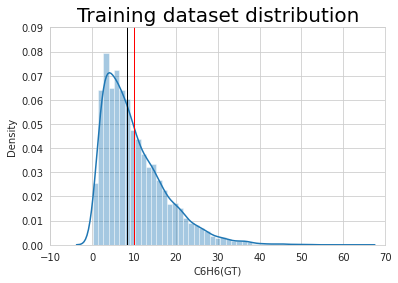

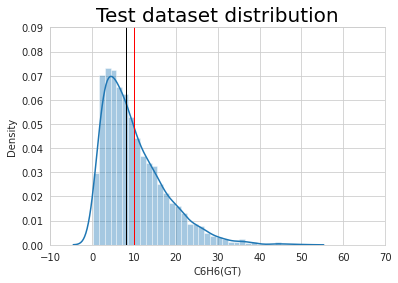

In [ ]:
fig, ax = plt.subplots()
sns.distplot(y_train_all, ax=ax)
plt.axvline(y_train_all.mean(), linewidth=1 , color = 'red')
plt.axvline(y_train_all.median(), linewidth=1 , color = 'black')
ax.set_xlim(-10,70)
ax.set_ylim(0,0.09)
plt.title(label="Training dataset distribution",
          fontsize=20,
          color="black")
plt.show();
fig, ax = plt.subplots()
sns.distplot(y_test, ax=ax)
plt.axvline(y_test.mean(), linewidth=1 , color = 'red')
plt.axvline(y_test.median(), linewidth=1 , color = 'black')
ax.set_xlim(-10,70)
ax.set_ylim(0,0.09)
plt.title(label="Test dataset distribution",
          fontsize=20,
          color="black")
plt.show()

## 1.3 Delete the Outliers

I will drop the outliers of the training dataset.

In [ ]:
# training dataframe with target variable
df_train = pd.concat([X_train_all, y_train_all], axis=1)

I wrote a function to help understand the right interval for letting out the outliers. The idea is to modify the multiplier of IQR such that we delete less than specific amout of data from our dataset. You pass to the function the range and the stepsize for the search of the multiplier and give the percentage less than which you are ready to delete the outliers. The function returns the multiplier k that is the lowest for that cause. Then you run the remove_outlier_dataframe function with that k and save the result.

In [ ]:
def remove_outlier(df_in, col_name, k):
    df = df_in.copy()
    q1 = df[col_name].quantile(0.25)
    q3 = df[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-k*iqr
    fence_high = q3+k*iqr
    # print(fence_low)
    df_null = df[df[col_name].isnull()]
    # print(df_null.shape)
    df = df[df[col_name] > fence_low]
    df = df[df[col_name] < fence_high]
    df = pd.concat([df_null, df])
    return df

def remove_outlier_dataframe(df_in, k):
  Current_df = df_in.copy()
  for col in list(data.select_dtypes('number').columns):
    Current_df = remove_outlier(Current_df, col, k)
  return Current_df

def optimal_range(df_in, a, b, step=0.01, percentage=0.01):
  for i in np.arange(a, b, step):
    df_out = remove_outlier_dataframe(df_in, i)
    # print(1 - (df_out.shape[0]/df_in.shape[0]))
    if 1 - (df_out.shape[0]/df_in.shape[0]) < percentage:
      return i
  return "Not in this range"

opt_k = optimal_range(df_train, 1, 10, step=0.2)
print(opt_k)

3.1999999999999993


In [ ]:
print(df_train.shape)
df_train = remove_outlier_dataframe(df_train, opt_k)
print(df_train.shape)

(6743, 15)
(6685, 15)


In [ ]:
df_train.reset_index(inplace=True, drop=True)

In [ ]:
y_train_all = df_train["C6H6(GT)"]
X_train_all = df_train.drop(["C6H6(GT)"], axis=1)

# 2. EDA

In [ ]:
descriptive_stats = df_train.describe(include='all')
print(descriptive_stats)

            CO(GT)  PT08.S1(CO)  PT08.S2(NMHC)      NOx(GT)  PT08.S3(NOx)  \
count  5432.000000  6685.000000    6685.000000  5485.000000   6685.000000   
mean      2.102872  1097.471653     935.565146   236.389061    834.394465   
std       1.362416   213.302429     260.790762   192.235582    247.386246   
min       0.100000   667.000000     383.000000     2.000000    346.000000   
25%       1.100000   936.000000     734.000000    97.000000    660.000000   
50%       1.800000  1062.000000     908.000000   177.000000    807.000000   
75%       2.800000  1228.000000    1111.000000   318.000000    965.000000   
max       8.600000  2040.000000    1866.000000  1028.000000   1938.000000   

           NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)            T           RH  \
count  5483.000000   6685.000000  6685.000000  6685.000000  6685.000000   
mean    111.651103   1453.969484  1017.092296    18.396066    49.126881   
std      46.888053    343.851749   390.945416     8.846154    17.387910   
min   

## 2.1 Correlation with Target Variable

Find the features highly correlated with the dependent variable.

CO(GT)           0.930248
PT08.S1(CO)      0.880190
PT08.S2(NMHC)    0.983529
NOx(GT)          0.695545
PT08.S3(NOx)    -0.751197
NO2(GT)          0.604217
PT08.S4(NO2)     0.769164
PT08.S5(O3)      0.861724
T                0.215087
RH              -0.069877
AH               0.178419
day_year_sin    -0.051214
day_week_sin     0.014895
hour_sin        -0.304582
C6H6(GT)         1.000000
Name: C6H6(GT), dtype: float64


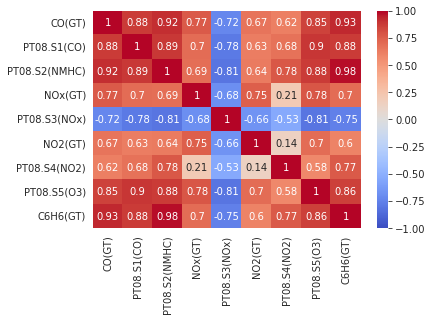

In [ ]:
corr = df_train.corr()
print(corr["C6H6(GT)"])
condition = np.abs(corr["C6H6(GT)"]) > 0.5
top_corr = corr.loc[condition, condition]
sns.heatmap(top_corr, cmap="coolwarm", vmin=-1, vmax=1, annot=True)

I will drop these columns because of very low correlation with the target variable.

In [ ]:
if "RH" in X_train_all.columns:
  X_train_all = X_train_all.drop(["RH"], axis=1)
  X_test = X_test.drop(["RH"], axis=1)
if "day_year_sin" in X_train_all.columns:
  X_train_all = X_train_all.drop(["day_year_sin"], axis=1)
  X_test = X_test.drop(["day_year_sin"], axis=1)
if "day_week_sin" in X_train_all.columns:
  X_train_all = X_train_all.drop(["day_week_sin"], axis=1)
  X_test = X_test.drop(["day_week_sin"], axis=1)

## 2.2 Visualization

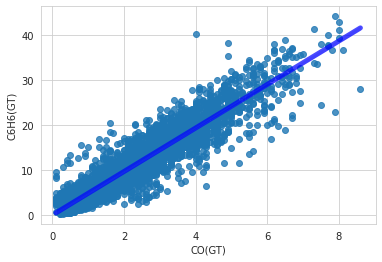

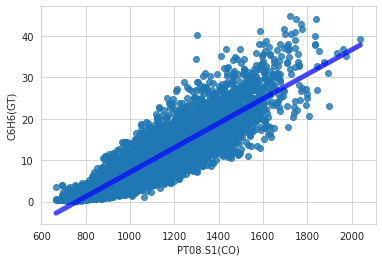

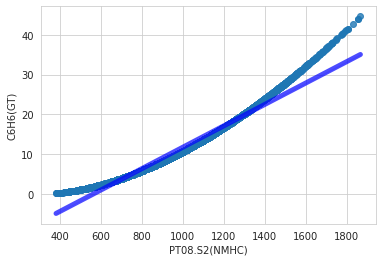

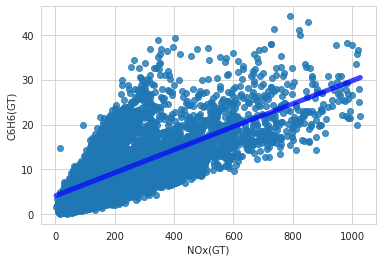

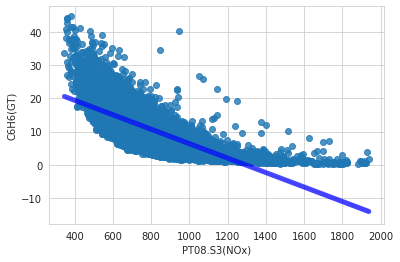

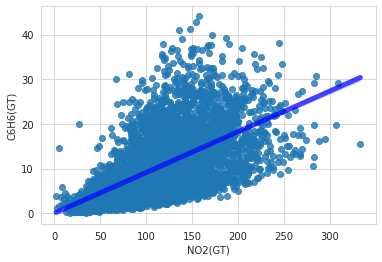

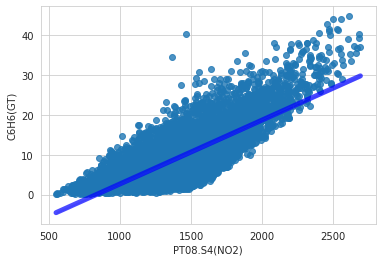

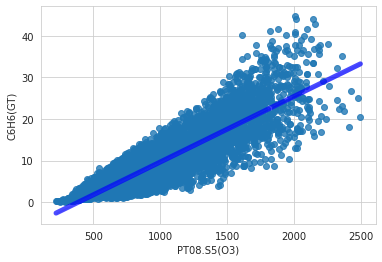

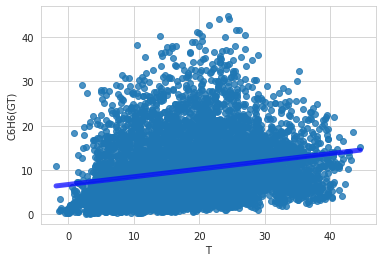

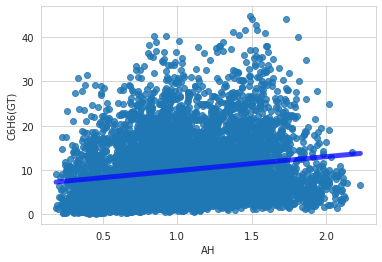

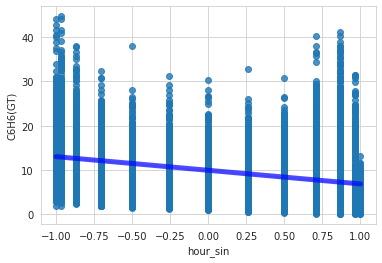

In [ ]:
# plots
for col in X_train_all.columns:
  sns.regplot(x=X_train_all[col], y=y_train_all, line_kws={"color":"b","alpha":0.7,"lw":5})
  plt.show()

We can see that some of the variables are connected to the target variable linearly. At the same time the realtionships of PT08.S1(CO), PT08.S2(NMHC) and PT08.S3(NOx) can be better described by a polynomial function. Thus we will try polinomial regression as well.

# 3. Regressions

In [ ]:
# Evaluation

def evaluate_model(train, val, tr_y, val_y, pipeline):
    pipeline.fit(train, tr_y)
    pred_val = pipeline.predict(val)
    pred_train = pipeline.predict(train)
    mapper = pipeline.named_steps['mapper']

    return pd.DataFrame({
        'train_RMSE': [np.sqrt(mean_squared_error(tr_y, pred_train))],
        'train_R2': [r2_score(tr_y, pred_train)],
        'val_RMSE': [np.sqrt(mean_squared_error(val_y, pred_val))],
        'val_R2': [r2_score(val_y, pred_val)]
    }), mapper.transformed_names_

## 3.1 Basic Linear Regression

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all,
                                                  random_state=seed, shuffle=True, test_size = 0.2)
X_train_all.reset_index(inplace=True, drop=True)
y_train_all.reset_index(inplace=True, drop=True)

In [ ]:
CONTINUOUS = X_train.select_dtypes(include=['float']).columns.tolist()
CYCLICAL = ["hour_sin"] #["day_sin", "hour_sin"]
for cyc in CYCLICAL:
  if cyc in CONTINUOUS:
    CONTINUOUS.remove(cyc)
print(CONTINUOUS, CYCLICAL)

['CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'AH'] ['hour_sin']


Here I will use IterativeImputer for imputation as there was high amount of data missing more than 15% noted earlier. So imputing with the help of the other column will be more accurate.

In [ ]:
imp_mean = IterativeImputer(random_state=seed)
X_train = pd.DataFrame(imp_mean.fit_transform(X_train), columns = X_train.columns)
X_val = pd.DataFrame(imp_mean.transform(X_val), columns = X_train.columns)
X_train_all = pd.DataFrame(imp_mean.fit_transform(X_train_all), columns = X_train_all.columns)
X_test = pd.DataFrame(imp_mean.transform(X_test), columns = X_train_all.columns)

In [ ]:
continuous_def = gen_features(
    columns=[[c] for c in CONTINUOUS],
    classes=[
        # {'class': IterativeImputer, 'max_iter': 10},
        {'class': StandardScaler}
    ]
)
cyclical_def = gen_features(
    columns=[[c] for c in CYCLICAL],
    classes=[
        # {'class': SimpleImputer, 'strategy': 'median'},
        {'class': StandardScaler}
    ]
)

In [ ]:
features = continuous_def + cyclical_def
mapper = DataFrameMapper(features)
len(features)

11

In [ ]:
X_train_tr = pd.DataFrame(mapper.fit_transform(X_train))
X_val_tr = pd.DataFrame(mapper.transform(X_val))

scaler = StandardScaler()
scaler.fit(np.array(y_train).reshape(-1, 1))
y_train_tr = scaler.transform(np.array(y_train).reshape(-1, 1))
y_val_tr = scaler.transform(np.array(y_val).reshape(-1, 1))

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train_tr, y_train_tr)
print(f'\nR2 Score: {linreg.score(X_val_tr, y_val_tr)}')


R2 Score: 0.9797502709989034


In [ ]:
#cross validation
def rmse(y_gt, Y_pr):
    return np.sqrt(mean_squared_error(y_gt, Y_pr))

print('RMSE val: ')
print(rmse(y_val_tr, linreg.predict(X_val_tr)))
print('-'*30)

rmse_scorer = metrics.make_scorer(rmse)
print('RMSE cross-validation scores:')
CV_score = cross_val_score(linreg, X_train_tr, y_train_tr, cv=5, scoring=rmse_scorer)
print(CV_score)
print('-'*30)

print('RMSE average cross-validation scores:')
print(np.sum(CV_score)/5)
print('-'*30)

RMSE val: 
0.1476273230355626
------------------------------
RMSE cross-validation scores:
[0.13940408 0.14256176 0.13640005 0.14250689 0.13569669]
------------------------------
RMSE average cross-validation scores:
0.13931389268128577
------------------------------


In [ ]:
#metrics
predictions = linreg.predict(X_val_tr)

mae = metrics.mean_absolute_error(y_val_tr, predictions)
mse = metrics.mean_squared_error(y_val_tr, predictions)
r2 = metrics.r2_score(y_val_tr, predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_val_tr, predictions))

pd.DataFrame.from_dict({'MAE':mae, 'MSE':mse, 'R2':r2, 'RMSE':rmse}, orient='index', columns=['Score'])

,Score
MAE,0.105079
MSE,0.021794
R2,0.979750
RMSE,0.147627


## 3.2 Polynomial Regression

### Feature Engineering

In [ ]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_train_all_poly = poly.fit_transform(X_train_all)
X_test_poly = poly.transform(X_test)
poly_columns = poly.get_feature_names_out(X_train_all.columns)
X_train_poly = pd.DataFrame(X_train_poly, columns=poly_columns)
X_val_poly = pd.DataFrame(X_val_poly, columns=poly_columns)
X_train_all_poly = pd.DataFrame(X_train_all_poly, columns=poly_columns)
X_test_poly = pd.DataFrame(X_test_poly, columns=poly_columns)

In [ ]:
CONTINUOUS = poly.get_feature_names_out(X_train.columns)
print(list(CONTINUOUS))

['1', 'CO(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'AH', 'hour_sin', 'CO(GT)^2', 'CO(GT) PT08.S1(CO)', 'CO(GT) PT08.S2(NMHC)', 'CO(GT) NOx(GT)', 'CO(GT) PT08.S3(NOx)', 'CO(GT) NO2(GT)', 'CO(GT) PT08.S4(NO2)', 'CO(GT) PT08.S5(O3)', 'CO(GT) T', 'CO(GT) AH', 'CO(GT) hour_sin', 'PT08.S1(CO)^2', 'PT08.S1(CO) PT08.S2(NMHC)', 'PT08.S1(CO) NOx(GT)', 'PT08.S1(CO) PT08.S3(NOx)', 'PT08.S1(CO) NO2(GT)', 'PT08.S1(CO) PT08.S4(NO2)', 'PT08.S1(CO) PT08.S5(O3)', 'PT08.S1(CO) T', 'PT08.S1(CO) AH', 'PT08.S1(CO) hour_sin', 'PT08.S2(NMHC)^2', 'PT08.S2(NMHC) NOx(GT)', 'PT08.S2(NMHC) PT08.S3(NOx)', 'PT08.S2(NMHC) NO2(GT)', 'PT08.S2(NMHC) PT08.S4(NO2)', 'PT08.S2(NMHC) PT08.S5(O3)', 'PT08.S2(NMHC) T', 'PT08.S2(NMHC) AH', 'PT08.S2(NMHC) hour_sin', 'NOx(GT)^2', 'NOx(GT) PT08.S3(NOx)', 'NOx(GT) NO2(GT)', 'NOx(GT) PT08.S4(NO2)', 'NOx(GT) PT08.S5(O3)', 'NOx(GT) T', 'NOx(GT) AH', 'NOx(GT) hour_sin', 'PT08.S3(NOx)^2', 'PT08.S3(NOx) NO2(GT)', 'PT08

In [ ]:
continuous_poly_def = gen_features(
    columns=[[c] for c in CONTINUOUS],
    classes=[
        # {'class': IterativeImputer, 'max_iter': 10},
        {'class': StandardScaler}
    ]
)

In [ ]:
features_poly = continuous_poly_def
mapper_poly = DataFrameMapper(features_poly)
len(features_poly)

78

In [ ]:
X_train_poly_tr = pd.DataFrame(mapper_poly.fit_transform(X_train_poly))
X_val_poly_tr = pd.DataFrame(mapper_poly.transform(X_val_poly))

scaler_poly = StandardScaler()
scaler_poly.fit(np.array(y_train).reshape(-1, 1))
y_train_poly_tr = scaler.transform(np.array(y_train).reshape(-1, 1))
y_val_poly_tr = scaler.transform(np.array(y_val).reshape(-1, 1))

In [ ]:
polyreg = LinearRegression()
polyreg.fit(X_train_poly_tr, y_train_poly_tr)
print(f'\nR2 Score: {polyreg.score(X_val_poly_tr, y_val_poly_tr)}')


R2 Score: 0.9999567045480198


In [ ]:
#metrics
predictions = polyreg.predict(X_val_poly_tr)

mae = metrics.mean_absolute_error(y_val_poly_tr, predictions)
mse = metrics.mean_squared_error(y_val_poly_tr, predictions)
r2 = metrics.r2_score(y_val_poly_tr, predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_val_poly_tr, predictions))

pd.DataFrame.from_dict({'MAE':mae, 'MSE':mse, 'R2':r2, 'RMSE':rmse}, orient='index', columns=['Score'])

,Score
MAE,0.005076
MSE,0.000047
R2,0.999957
RMSE,0.006826


## 3.3 Linear or Polynomial (Optional)

I will try to find the best power of polinomials for the model by a grid search.

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

param_grid = [
    {'mapper__degree': [1, 2]}
  ]
pipeline = Pipeline(steps=[('mapper', PolynomialFeatures()), ('lg', LinearRegression())])
grid_search = GridSearchCV(pipeline, param_grid, cv=cv,
                           scoring=['neg_mean_squared_error', 'r2'],
                           refit='neg_mean_squared_error')

In [ ]:
grid_search.fit(pd.DataFrame(mapper.fit_transform(X_train_all)), scaler.transform(np.array(y_train_all).reshape(-1, 1)))

GridSearchCV(cv=KFold(n_splits=5, random_state=2023, shuffle=True),
             estimator=Pipeline(steps=[('mapper', PolynomialFeatures()),
                                       ('lg', LinearRegression())]),
             param_grid=[{'mapper__degree': [1, 2]}],
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'r2'])

In [ ]:
grid_search.best_params_

{'mapper__degree': 2}

According to the grid search algorithm the optimal regression is the polynomial regression. This is quite natural as we increase the number of feature, so we will have a higher R Squared value. It would be more usefull to use Adjusted R Squared value for this cause, however the LinearRegression() model metrics does not have the Adjusted R Squared value. I will leave this code as well here as it was part of the experimentation.

## 3.4 Regularization and Hyperparameters Tuning

If you want to scale data before trying the elatic net model just uncomment the scaler line in the pipline in the code below.

In [ ]:
continuous_poly_def = gen_features(
    columns=[[c] for c in CONTINUOUS],
    classes=[
        # {'class': IterativeImputer, 'max_iter': 10},
        # {'class': StandardScaler}
    ]
)

In [ ]:
features_poly = continuous_poly_def
mapper_poly = DataFrameMapper(features_poly)
len(features_poly)

78

I will use regularization on the polynomial feature, it will help filter out the unrelated feature and result in a better model.

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=seed)
pipeline = Pipeline([
    ('mapper', DataFrameMapper(features_poly)),
    ('estimator', ElasticNet(random_state=seed))
])
grid = {
    'estimator__alpha': np.linspace(0, 300, 10),
    'estimator__l1_ratio': np.arange(0, 1.1, 0.1)
}
gs = GridSearchCV(pipeline, grid,
                  n_jobs=-1,
                  scoring=['neg_mean_squared_error', 'r2'],
                  refit='neg_mean_squared_error',
                  cv=cv)

In [ ]:
%%time
gs.fit(X_train_poly, y_train)

CPU times: user 4.74 s, sys: 401 ms, total: 5.14 s
Wall time: 2min 27s


GridSearchCV(cv=KFold(n_splits=5, random_state=2023, shuffle=True),
             estimator=Pipeline(steps=[('mapper',
                                        DataFrameMapper(features=[(['1'], None),
                                                                  (['CO(GT)'],
                                                                   None),
                                                                  (['PT08.S1(CO)'],
                                                                   None),
                                                                  (['PT08.S2(NMHC)'],
                                                                   None),
                                                                  (['NOx(GT)'],
                                                                   None),
                                                                  (['PT08.S3(NOx)'],
                                                                   None),
                 

In [ ]:
gs.best_params_

{'estimator__alpha': 33.333333333333336, 'estimator__l1_ratio': 0.1}

In [ ]:
pipeline = clone(pipeline)
pipeline.set_params(**gs.best_params_);

scores, col = evaluate_model(X_train_poly, X_val_poly, y_train, y_val, pipeline)
scores

,train_RMSE,train_R2,val_RMSE,val_R2
0,0.086154,0.999853,0.085557,0.999865


If I do scaling before training the elastic net the optimal hyperparameters are both equal to 0. Thus furter I will just use the polynomial linear regression with scaling.

## 3.5 Feature Importance

### Lasso for Linear

In [ ]:
def plot_importance(est, colnames, top_n=20):
    importance = pd.DataFrame({
        'abs_weight': np.abs(est.coef_),
        'feature': colnames
    })
    imp20 = importance.sort_values(by='abs_weight', ascending=False)[:top_n]
    sns.barplot(y='feature', x='abs_weight', data=imp20, orient='h');

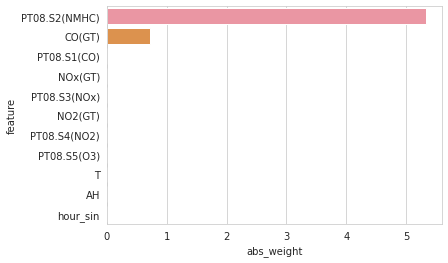

In [ ]:
lasso = Lasso()
pipeline = Pipeline([('mapper', DataFrameMapper(features)),
                     ('estimator', lasso)])

scores, colnames = evaluate_model(X_train, X_val, y_train, y_val, pipeline)
scores

plot_importance(pipeline.named_steps['estimator'], colnames)

We can see that the most correlated feature PT08.S2(NMHC) with the target value comes to play the largest effect in the regression.

### Ridge for Polynomial

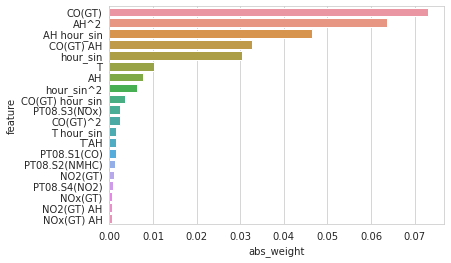

In [ ]:
ridge = Ridge()
pipeline = Pipeline([('mapper', DataFrameMapper(features_poly)),
                     ('estimator', ridge)])

scores, colnames = evaluate_model(X_train_poly, X_val_poly, y_train, y_val, pipeline)
scores

plot_importance(pipeline.named_steps['estimator'], colnames)

Here we can see that the PT08.S2(NMHC) of power 2 does a better job in the model of explaining the variance in the target variable.

# 4. Results

Try the 2 main models on the test data and compare the results.

## 4.1 Linear Regression Results

In [ ]:
X_train_all_tr = pd.DataFrame(mapper.fit_transform(X_train_all))
X_test_tr = pd.DataFrame(mapper.transform(X_test))

scaler = StandardScaler()
scaler.fit(np.array(y_train_all).reshape(-1, 1))
y_train_all_tr = scaler.transform(np.array(y_train_all).reshape(-1, 1))
y_test_tr = scaler.transform(np.array(y_test).reshape(-1, 1))

This time we train on the whole training dataset.

In [ ]:
linreg_final = LinearRegression()
linreg_final.fit(X_train_all_tr, y_train_all_tr)
print(f'\nR2 Score: {linreg_final.score(X_test_tr, y_test_tr)}')


R2 Score: 0.9791392525747269


In [ ]:
#metrics
predictions = linreg_final.predict(X_test_tr)

mae = metrics.mean_absolute_error(y_test_tr, predictions)
mse = metrics.mean_squared_error(y_test_tr, predictions)
r2 = metrics.r2_score(y_test_tr, predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test_tr, predictions))

pd.DataFrame.from_dict({'MAE':mae, 'MSE':mse, 'R2':r2, 'RMSE':rmse}, orient='index', columns=['Score'])

,Score
MAE,0.105748
MSE,0.022117
R2,0.979139
RMSE,0.148719


## 4.2 Polynomial Regression Results

In [ ]:
X_train_all_poly_tr = pd.DataFrame(mapper_poly.fit_transform(X_train_all_poly))
X_test_poly_tr = pd.DataFrame(mapper_poly.transform(X_test_poly))

scaler_poly = StandardScaler()
scaler_poly.fit(np.array(y_train_all).reshape(-1, 1))
y_train_all_poly_tr = scaler.transform(np.array(y_train_all).reshape(-1, 1))
y_test_poly_tr = scaler.transform(np.array(y_test).reshape(-1, 1))

In [ ]:
polyreg_final = LinearRegression()
polyreg_final.fit(X_train_all_poly_tr, y_train_all_poly_tr)
print(f'\nR2 Score: {polyreg_final.score(X_test_poly_tr, y_test_poly_tr)}')


R2 Score: 0.999955233381445


In [ ]:
#metrics
predictions = polyreg_final.predict(X_test_poly_tr)

mae = metrics.mean_absolute_error(y_test_poly_tr, predictions)
mse = metrics.mean_squared_error(y_test_poly_tr, predictions)
r2 = metrics.r2_score(y_test_poly_tr, predictions)
rmse = np.sqrt(metrics.mean_squared_error(y_test_poly_tr, predictions))

pd.DataFrame.from_dict({'MAE':mae, 'MSE':mse, 'R2':r2, 'RMSE':rmse}, orient='index', columns=['Score'])

,Score
MAE,0.005130
MSE,0.000047
R2,0.999955
RMSE,0.006889


We got very high R Squared value on the test set as well indicating that we had not overtrained the model on the training dataset.

## 4.3 Error Visualization

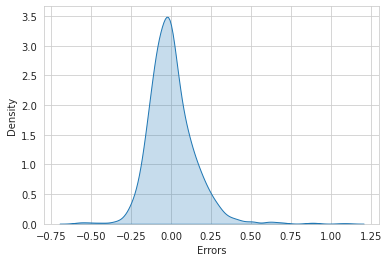

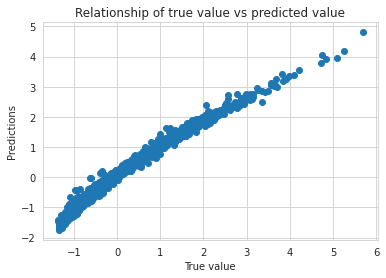

In [ ]:
#errors visualization
#can be helpful to better understand behavior of model

predictions = linreg_final.predict(X_test_tr)
errors = y_test_tr - predictions
errors_df = pd.DataFrame(errors, columns = ["Errors"]).set_index(pd.RangeIndex(start=1, stop=len(errors)+1, step=1))

sns.kdeplot(data=errors_df, x="Errors", shade=True)
plt.show()

plt.scatter(y_test_tr, predictions);
plt.title('Relationship of true value vs predicted value')
plt.ylabel('Predictions');
plt.xlabel('True value');
plt.show();

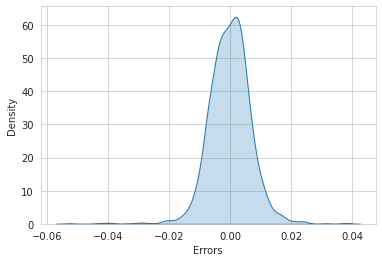

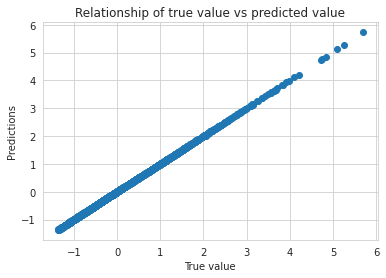

In [ ]:
#errors visualization
#can be helpful to better understand behavior of model

predictions = polyreg_final.predict(X_test_poly_tr)
errors = y_test_poly_tr - predictions
errors_df = pd.DataFrame(errors, columns = ["Errors"]).set_index(pd.RangeIndex(start=1, stop=len(errors)+1, step=1))

sns.kdeplot(data=errors_df, x="Errors", shade=True)
plt.show()

plt.scatter(y_test_poly_tr, predictions);
plt.title('Relationship of true value vs predicted value')
plt.ylabel('Predictions');
plt.xlabel('True value');
plt.show();

We can clearly see that despite errors for both models are normally distributed, errors of the polynomial model are much densly distributed around 0 than those of the linear model(the desity polts have different scales pay attention to the number on x axis, I did not equalize the graph scales as the normal distribution of the errors of the polynomial model would not be visible.)

To sum up, I would choose the polynomial regression over the linear regression as it does better job to explain the variance of the target value, it offers more precision without overfitting.

## 4.4 Factor-Importance Hypothesis Testing

In [ ]:
# import statsmodels.api as sm

X_train_lm = sm.add_constant(X_train_all_poly)
lm = sm.OLS(y_train_all, X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               C6H6(GT)   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.078e+06
Date:                Tue, 10 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:57:45   Log-Likelihood:                 11098.
No. Observations:                6685   AIC:                        -2.204e+04
Df Residuals:                    6607   BIC:                        -2.151e+04
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
1                   

We can check the P value if higher than 0.05 we can delete those columns as their coeffitients are not significantly different from 0. That will help us to make the model even lighter without loosing precision.